In [2]:
import numpy as np
import scipy.stats as st
import pylab as plt
import pandas as pd
import seaborn as sns

In [7]:
def phi(d, precision=30): 
    x = 2.00
    for i in range(precision): 
        x = pow(1+x,1/(d+1)) 
    return x

"""
golden ratios to fill up the space in the most efficient way:

in more dimension: Markov number.
"""

"""

"""

'\n\n'

In [9]:
def gaussian_icdf(q):
    return st.norm.isf(q)

def identity(x):
    return x

"""
mapping function, we want to generate every low discrepancy number we want
for convienince we will use 2: Identity = U(0,1) and simplest implementation with normal distro
"""


'\nmapping function, we want to generate every low discrepancy number we want\nfor convienince we will use 2: Identity = U(0,1) and simplest implementation with normal distro\n'

In [10]:

def a_generate(ndim, Npoints, *, seed=0.5, mapper=identity):
    # get the base for the dimension
    g = phi(ndim) #next number of the markov number ?
    
    # this is the inizialization constant for the array
    alpha = ((1/g)**np.arange(1, ndim+1))%1  #golden ration
    
    # reshaping to allow broadcasting
    alpha = alpha.reshape(1, -1) 
    
    # just the count of the sequence
    base = np.arange(Npoints).reshape(-1, 1) 
    
    # perform the actual calculation
    z = seed + alpha*base 
    
    # tale only the decimal part
    z = z % 1
    # return a mapped version to some distribution
    return mapper(z) #mapping function.

"""
just implementation of the algorithm discussed last lesson. return a sequence of randomly distributed number 
by selcting the mapping function.
"""

'\njust implementation of the algorithm discussed last lesson. return a sequence of randomly distributed number \nby selcting the mapping function.\n'

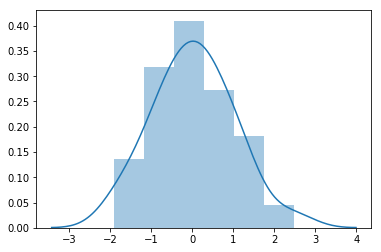

In [18]:
rn = a_generate(1,30,mapper = gaussian_icdf)
sns.distplot(rn) #example

[]

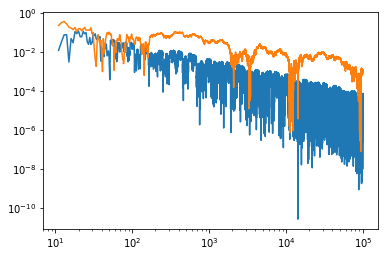

In [20]:
N = 100_000 
x_r = a_generate(1, N, mapper=gaussian_icdf) #low discrepancy sequence
x_g = plt.randn(N) 

n = np.arange(1, len(x_r)+1)
res_r = np.cumsum(x_r)/n
res_g = np.cumsum(x_g)/n

r = 10
plt.plot(n[r:], abs(res_r)[r:])
plt.plot(n[r:], abs(res_g)[r:])
plt.loglog()

#blue = low discrepancy
#red = random number gen.

#extimation of the error doone by extimating the average.

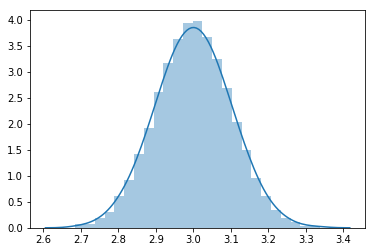

In [22]:
b0 = a_generate(1, 1000, mapper=st.norm(loc=3, scale=0.1).isf)
sns.distplot(b0) #can use every mapper I want. its sufficient that it has an inverse tho.

In [23]:
from scipy.integrate import odeint

# derivative
def logistic(state, time, α, β):
    N = state
    δN = α*N - β*N**2 #simplest version, variation on N is this one.
    return δN #it describe completely the differential equation.

# time steps
time = np.linspace(0, 1, 2**7+1) #strange number of points? decimal numbers are not a great base actually. 
                                 #that's a base two representation 

# starting status
N0 = 0.1

# parameters
α = 10
β = 1

#in general we solve a cauchy problem numerically, from a starting point.

In [30]:
res = odeint(logistic,y0 = N0,t = time, args = (α,β)) #and it's done.

In [35]:
res.shape #(number of steps, number of variable to integrate)

(129, 1)

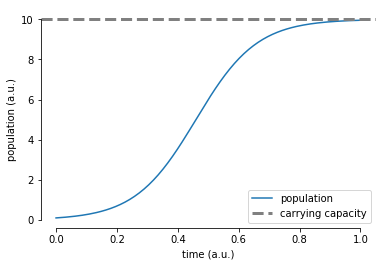

In [43]:
fig, ax = plt.subplots()
ax.plot(time, res, label="population")
ax.set_xlabel("time (a.u.)")
ax.set_ylabel("population (a.u.)")
ax.axhline(α/β, label='carrying capacity', color='gray', linewidth=3, linestyle='--') #convergence to α/β O_O
ax.legend()
sns.despine(fig, trim=True)

In [45]:
#transform with pandas.

def to_df(result, columns, **other_info):
    res_df = pd.DataFrame(result, columns=columns)
    for key, value in other_info.items():
        res_df[key] = value
    return res_df

In [48]:
to_df(res, ["population"], α = α, β = β, time = time).head()

,population,α,β,time
0,0.100000,10,1,0.000000
1,0.108038,10,1,0.007812
2,0.116714,10,1,0.015625
3,0.126079,10,1,0.023438
4,0.136184,10,1,0.031250


In [49]:
#how does my equation change by randomly changing a parameter? will the solutionn and convergence change?
#for the logistic equation that does not really prove anything, 
#but for more complicated eqaution it show how the sistem behave

In [51]:
mapper = st.norm(loc=[10], scale=0.5).isf
# 50 values around the average value
alphas = a_generate(1, 50, mapper=mapper) #generate 50 low discrepancy number
β = 1

time = np.linspace(0, 1, 2**7+1)

results = [] 
for idx, (α, ) in enumerate(alphas): #α unpacked as a tuple, so that it does not recieve an array 
    res = odeint(logistic, y0=N0, t=time, args=(α, β))
    
    res_df = to_df(res, ['population'], 
                   α=α, β=β, time=time, simulation_run = idx) #idx used to numerate run
    results.append(res_df)
    
results = pd.concat(results) 

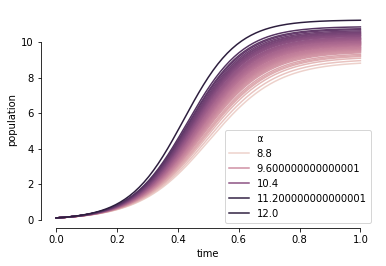

In [55]:
sns.lineplot("time", 'population', 
             data = results, 
             hue = 'α',
             estimator=None, units='simulation_run')
sns.despine(trim = True)

In [57]:
#same thing for beta

mapper = st.norm(loc=[10], scale=0.5).isf
# 50 values around the average value
betas = a_generate(1, 50, mapper=mapper) #generate 50 low discrepancy number
α = 10

time = np.linspace(0, 1, 2**7+1)

results = [] 
for idx, (β, ) in enumerate(betas): #α unpacked as a tuple, so that it does not recieve an array 
    res = odeint(logistic, y0=N0, t=time, args=(α, β))
    res_df = to_df(res, ['population'], 
                   α=α, β=β, time=time, simulation_run = idx) #idx used to numerate run
    results.append(res_df)
results = pd.concat(results)

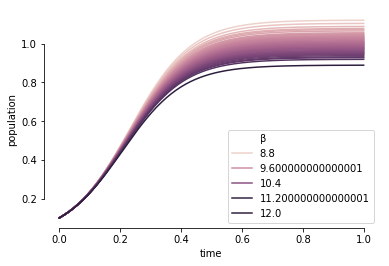

In [59]:
sns.lineplot("time", 'population', 
             data = results, 
             hue = 'β',
             estimator=None, units='simulation_run')
sns.despine(trim = True)

In [60]:
#the two graph show that the shape dows not change. But the carrying capacity change a lot!
#for β the convergence does not change that much 
#for α instead also the speed of convergence change 

In [61]:
#change in logistic eq.
def logistic_bis(state, time, α, β):
    N = state
    δN = α*N - β*N**2 
    δN = α*N*(1-N/β)
    return δN 

In [65]:
mapper = st.norm(loc=[10], scale=0.5).isf
# 50 values around the average value
alphas = a_generate(1, 50, mapper=mapper) #generate 50 low discrepancy number
β = 1

time = np.linspace(0, 1, 2**7+1)

results = [] 
for idx, (α, ) in enumerate(alphas): #α unpacked as a tuple, so that it does not recieve an array 
    res = odeint(logistic_bis, y0=N0, t=time, args=(α, β))
    res_df = to_df(res, ['population'], 
                   α=α, β=β, time=time, simulation_run = idx) #idx used to numerate run
    results.append(res_df)
results = pd.concat(results)

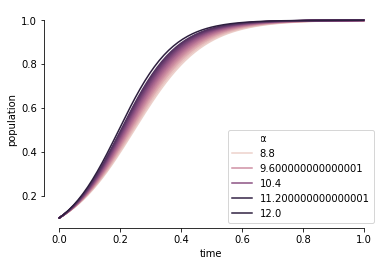

In [66]:
sns.lineplot("time", 'population', 
             data = results, 
             hue = 'α',
             estimator=None, units='simulation_run')
sns.despine(trim = True)

In [70]:
# and now for the betas

mapper = st.norm(loc=[10], scale=0.5).isf
# 50 values around the average value
betas = a_generate(1, 50, mapper=mapper) #generate 50 low discrepancy number
α = 10

time = np.linspace(0, 1, 2**7+1)

results = [] 
for idx, (β, ) in enumerate(betas): #α unpacked as a tuple, so that it does not recieve an array 
    res = odeint(logistic_bis, y0=N0, t=time, args=(α, β))
    res_df = to_df(res, ['population'], 
                   α=α, β=β, time=time, simulation_run = idx) #idx used to numerate run
    results.append(res_df)
results = pd.concat(results)

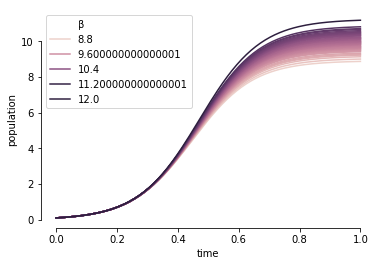

In [69]:
sns.lineplot("time", 'population', 
             data = results, 
             hue = 'β',
             estimator=None, units='simulation_run')
sns.despine(trim = True)

In [71]:
#beta control where the convergence is (same speed)
#same value but different speed. the system is alwayse the same tho.
#what changes is when we start to tallk about the value of correlations between parameter.

In [73]:
#Sir Model.

def SIR_model(state, time, α, β, γ):
    S, I, R, D = state
    δR = + α*I
    δD = + γ*I
    δI = - γ*I - α*I + β*I*S
    δS = - β*I*S
    return δS, δI, δR, δD 
    
time = np.linspace(0, 5, 2**9+1)
state0 = (1.0, 0.001, 0.0, 0.0)
α, β, γ = 1, 10, 0.3

res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))

In [74]:
S_hat, I_hat, R_hat, D_hat = res.T

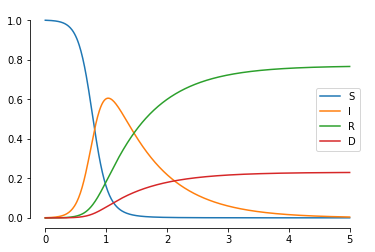

In [76]:
plt.plot(time, S_hat, label='S')
plt.plot(time, I_hat, label='I')
plt.plot(time, R_hat, label='R')
plt.plot(time, D_hat, label='D')

plt.legend()
sns.despine(trim = True)

In [78]:
#with different param.

Nexp = 50
results = []
state0 = (1.0, 0.001, 0.0, 0.0)
α, β, γ = 1.0, 10.0, 0.3
α_seq = a_generate(1, Nexp, mapper=st.norm(loc=[1], scale=0.1).isf)

cols = ['S', 'I', 'R', 'D']
for idx, (α, ) in enumerate(α_seq):
    res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
    res_df = to_df(res, cols, N0=N0, α=α, β=β, γ=γ, time=time, simulation_run=idx, type='varying a')
    results.append(res_df)
results = pd.concat(results, ignore_index=True)

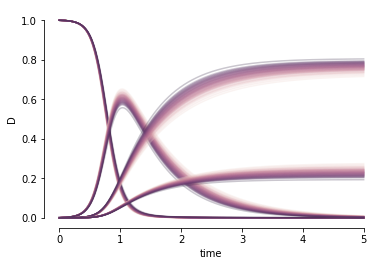

In [87]:
alpha = 0.25
args = dict(data=results, estimator=None, 
            units='simulation_run', 
            alpha=alpha, 
            hue = "α", 
            legend = False ) #nice, passing results as a 
sns.lineplot("time", 'S', **args)
sns.lineplot("time", 'I', **args)
sns.lineplot("time", 'R', **args)
sns.lineplot("time", 'D', **args)
sns.despine(trim = True)

àone would think tha onlyy the amount of resintant would change, but that's infact not the case 

we can also make global sensitivity analisys


In [88]:
#How to fit now ?


scale = 100

time = np.linspace(0, 5, 2**5+1)
state0 = (1.0, 0.001, 0.0, 0.0)
α, β, γ = 1, 10, 0.3
res = odeint(SIR_model, y0=state0, t=time, args=(α, β, γ))
S_hat, I_hat, R_hat, D_hat = res.T

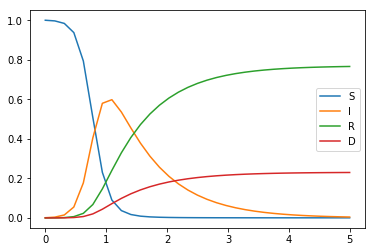

In [89]:
plt.plot(time, S_hat, label='S')
plt.plot(time, I_hat, label='I')
plt.plot(time, R_hat, label='R')
plt.plot(time, D_hat, label='D')

plt.legend()

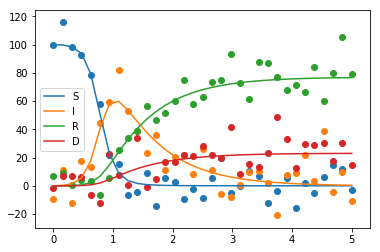

In [91]:
S_hat_normal, I_hat_normal, R_hat_normal, D_hat_normal = st.norm.rvs(loc=res*scale, scale=0.1*scale).T

plt.plot(time, S_hat*scale, label='S')
plt.plot(time, I_hat*scale, label='I')
plt.plot(time, R_hat*scale, label='R')
plt.plot(time, D_hat*scale, label='D')

plt.scatter(time, S_hat_normal)
plt.scatter(time, I_hat_normal)
plt.scatter(time, R_hat_normal)
plt.scatter(time, D_hat_normal)

plt.legend()

#we might want to use some more specific rng, this goes negative!

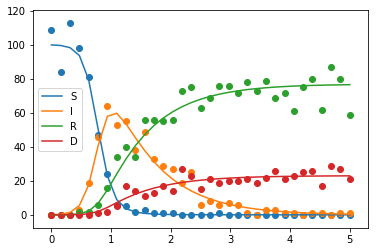

In [95]:
#Poisson number:
S_hat_poisson, I_hat_poisson, R_hat_poisson, D_hat_poisson = st.poisson.rvs(res*scale).T

plt.plot(time, S_hat*scale, label='S')
plt.plot(time, I_hat*scale, label='I')
plt.plot(time, R_hat*scale, label='R')
plt.plot(time, D_hat*scale, label='D')

plt.scatter(time, S_hat_poisson)
plt.scatter(time, I_hat_poisson)
plt.scatter(time, R_hat_poisson)
plt.scatter(time, D_hat_poisson)

plt.legend()

#now value are zeroes, ones, twos etc....

In [97]:
# but we assume random noise around averages, does not always make sense, but it can be indeed useful

In [100]:
#fitting with curve_fit

from scipy.optimize import curve_fit

#ydata = f(xdata, *params) + eps

#

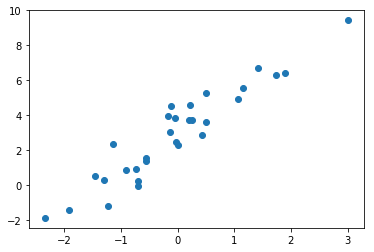

In [108]:
x = plt.randn(30)
y = 2*x + 3 + plt.randn(30)*0.8
plt.scatter(x, y)

In [109]:
def linear_fit(xdata, m, q):
    return m*xdata + q

p_avg, p_cov = curve_fit(linear_fit, x, y, p0=[1, 0])

#we need to make assumption on where we want to start, Hypothesis!

#we also have the covariance matrix

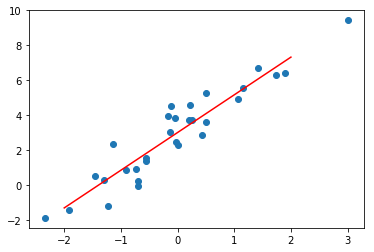

In [110]:
x_base = np.linspace(-2, 2, 51)
y_hat = linear_fit(x_base, *p_avg)
plt.scatter(x, y)
plt.plot(x_base, y_hat,color = "r")

In [111]:
#we want uncorrelated parameter tho, but it could be easier to parametrize our data with a simple linear fit ???